# Synapses

- Synaptic filter
- PSC after 1 spike
- PSC after many spikes
- PSC during constant firing

In [2]:
# Standard imports
import numpy as np
import matplotlib.pylab as plt
import ipywidgets as widgets
# The osx backend allows me to interact with the pywidgets.
# I find I have to run this cell twice. ???
%matplotlib osx
#%matplotlib inline

# Helper code

In [10]:
import math
def Spikes2PSC(t, spike_times, tau_s, n=0):
    ''' psc = Spikes2PSC(t, spike_times, tau_s, n=0) '''
    psc = np.array(np.zeros(t.shape))
    for spike in spike_times:
        psc = psc + PSCFilter(t, tau_s, spike, n)
    return psc

def PSCFilter(t, tau_s, t0=0, n=1):
    ''' psc_filter = PSCFilter(t, tau_s, t0=0, n=1)
        t is an array of times,
        tau_s is the synaptic time constant (eg. 0.01 s),
        t0 is the time for the spike,
        n is the power of the curve (see notes).
    '''
    t2 = t-t0
    xc = t2**n * np.exp(-t2/tau_s)
    xc[t2<0] = 0
    # Normalize the filter so that its integral is 1
    #pdb.set_trace() # this sets a breakpoint
    integral = math.factorial(n)*tau_s**(n+1)
    xc = xc / integral
    return xc

def PlotSpikeRaster(st, y_range=[0, 1.]):
    '''
    PlotSpikeRaster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times, like that returned
          by the function Stim2Spikes.
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons

    levels = np.linspace(y_range[0], y_range[1], N+1, endpoint=True)
    for n in range(N):
        nspikes = len(st[n])
        y = [ [levels[n]]*nspikes , [levels[n+1]]*nspikes ]
        #y = y_range[0] + [levels[n]]*nspikes
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim(y_range)
    return

def DemoSpikeTrain(P, T, random=False, jitter=0.):
    '''
    A = DemoSpikeTrain(P, T)
    Creates a spike train with average firing rate P over T seconds.
    If random is False, the spikes are uniformly spaced.
    '''
    if random:
        A = np.random.rand(int(P*T))*T
    else:
        A = np.arange(0., T, 1./P)

    A += np.random.normal(size=(len(A))) * jitter
    return np.sort(A)

# Spike Train

In [11]:
%matplotlib inline

Spike times:
[0.05868126 0.14996266 0.20727229 0.23395506 0.5352535  0.6122114
 0.6391426  0.84328512 0.90323179 1.08212147 1.21444511 1.30422738
 1.57804334 1.70576829 1.70840467 1.87468852 1.92010576 1.9995048 ]


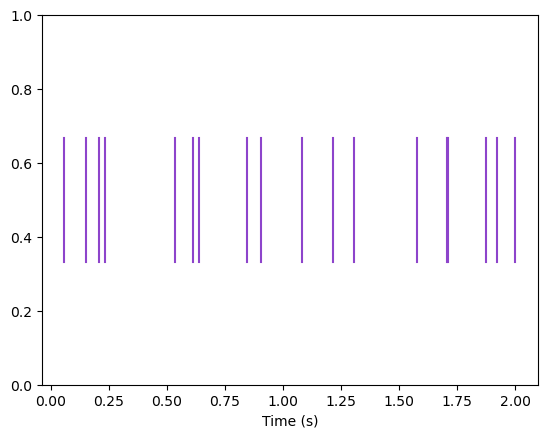

In [13]:
A = DemoSpikeTrain(9, 2, random=True)
print(f'Spike times:\n{A}')
PlotSpikeRaster([[],A,[]])
plt.xlabel('Time (s)');

# Synaptic Filter

In [14]:
def SynapticFilter(t, offset=0., tau_s=0.05, n=0):
    if t<offset:
        return 0.
    else:
        return (t-offset)**n*np.exp(-(t-offset)/tau_s)

In [15]:
%matplotlib osx

In [16]:
# Try tau_s values of 0.005, 0.03, 0.1
tau_s = 0.150
t = np.linspace(0, 1, 1000)
dt = t[1]-t[0]
s = np.array([SynapticFilter(tt, tau_s=tau_s, offset=0.0, n=0) for tt in t])
s = s / sum(s) / dt
fig = plt.figure(1); ax = fig.add_subplot(1,1,1)
line, = ax.plot(t,s); ax.set_xlabel('Time (s)'); ax.set_ylabel('PSC');

def update(tau_s=0.015):
    s = np.array([SynapticFilter(tt, tau_s=tau_s, offset=0.0, n=2) for tt in t])
    s = s / sum(s) / dt
    line.set_ydata(s)
    fig.canvas.draw_idle()

blah = widgets.interact(update, tau_s=widgets.FloatSlider(value=0.01, min=0.001, max=0.5, step=0.001, readout_format='.3f'))

interactive(children=(FloatSlider(value=0.01, description='tau_s', max=0.5, min=0.001, readout_format='.3f', s…

## Area under the curve

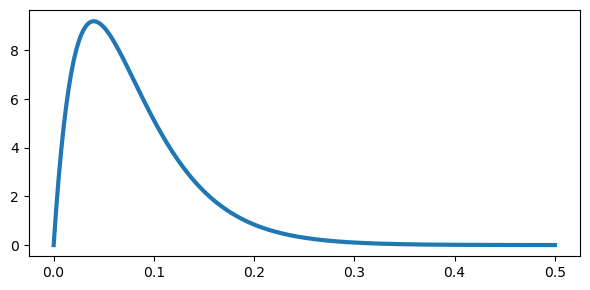

In [20]:
# A single spike at t=0
t3 = np.linspace(0, 0.5, 200)
p3 = Spikes2PSC(t3, [[0]], 0.04, 1)
plt.figure(figsize=(6,3))
plt.plot(t3, p3, linewidth=3);
plt.tight_layout()
plt.savefig('psc.pdf')

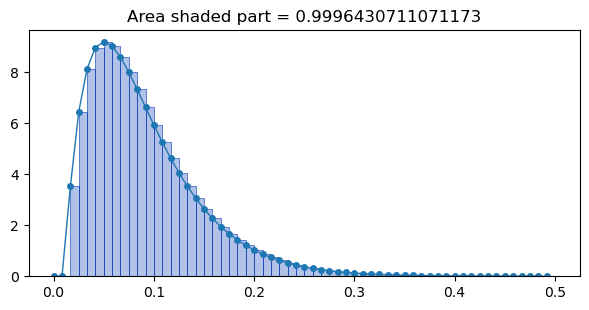

In [25]:
# Let's sample the curve
t3 = np.linspace(0.0, 0.5, 60, endpoint=False)
dt = t3[1] - t3[0]  # sample spacing
p3 = Spikes2PSC(t3, [[0.01]], 0.04, 1)
plt.figure(figsize=(6,3))
plt.plot(t3, p3, 'o-', linewidth=1, markersize=4);
plt.tight_layout()
plt.savefig('psc.pdf')
plt.bar(t3, p3, dt, color=(0,0.2,0.7,0.3), align='edge', linewidth=0.5, edgecolor=(0,0.2,0.7,0.8));
plt.title(f'Area shaded part = {np.sum(p3*dt)}');

# Filtered spike trains

## Convolving a one spike with the synaptic filter

In [28]:
%matplotlib inline

In [29]:
T = 1
dt = 0.001
t2 = np.arange(0.0, T, dt)

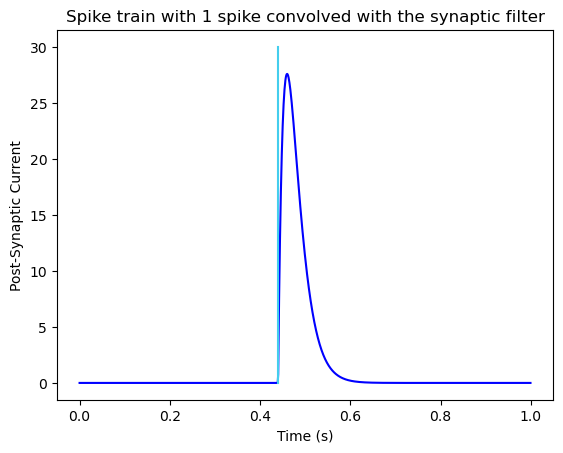

In [30]:
A = np.random.random(size=[1])*T  # choose a random spike time
p2 = Spikes2PSC(t2, A, 0.02, 1)
%matplotlib inline
plt.figure()
plt.plot(t2,1.5*p2,'b'), plt.xlabel('Time (s)'), plt.ylabel('Post-Synaptic Current')
PlotSpikeRaster([A], y_range=[0, 30]), plt.axis('auto');
plt.title(f'Spike train with 1 spike convolved with the synaptic filter');

## Many Spikes

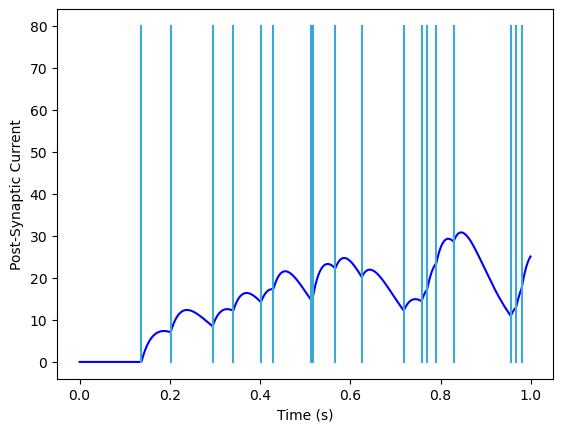

In [ ]:
P = 18   # Firing Rate
A = DemoSpikeTrain(P, T, random=True)
p2 = Spikes2PSC(t2, A, 0.05, 1) # try changing tau_s (0.01, or 0.1)
%matplotlib inline
plt.figure()
plt.plot(t2,p2,'b'), plt.xlabel('Time (s)'), plt.ylabel('Post-Synaptic Current')
PlotSpikeRaster([A], y_range=[0, 80]), plt.axis('auto');

In [32]:
p2 = Spikes2PSC(t2, A, 0.03, 1) # try changing tau_s (0.01, or 0.1)
%matplotlib osx
fig = plt.figure(); ax = fig.add_subplot(1,1,1)

PlotSpikeRaster([A], y_range=[0, 80]), ax.axis('auto');
line, = ax.plot(t2,p2,'b'); ax.set_xlabel('Time (s)'); ax.set_ylabel('Post-Synaptic Current')

def update(tau_s=0.1):
    p2 = Spikes2PSC(t2, A, tau_s, 2)
    line.set_ydata(p2)
    fig.canvas.draw_idle()
    
widgets.interact(update, tau_s=widgets.FloatSlider(value=0.05, min=0.001, max=0.2, step=0.001));

interactive(children=(FloatSlider(value=0.05, description='tau_s', max=0.2, min=0.001, step=0.001), Output()),…

## Constant Firing

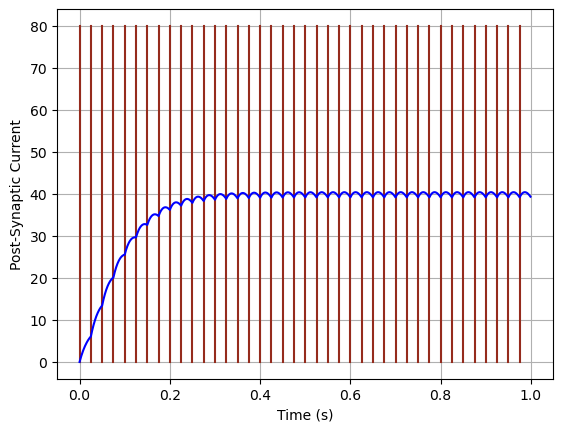

In [ ]:
P = 40   # Firing Rate

A = DemoSpikeTrain(P, T)
p2 = Spikes2PSC(t2, A, 0.05, 1)
%matplotlib inline
plt.figure()
PlotSpikeRaster([A], y_range=[0, 80]); plt.axis('auto'); plt.grid('on')
plt.plot(t2,p2,'b'); plt.xlabel('Time (s)'); plt.ylabel('Post-Synaptic Current');

# Total Input Current

## Combining spikes from multiple neurons

In [36]:
T = 2
dt = 0.001
t2 = np.arange(0.0, T, dt)

A = DemoSpikeTrain(9, T, random=True)
B = DemoSpikeTrain(12, T, random=True)

In [37]:
w_AC = 0.4
w_BC = -0.25

In [38]:
p_AC = Spikes2PSC(t2, A, tau_s=0.06, n=1)
p_BC = Spikes2PSC(t2, B, tau_s=0.1, n=1)

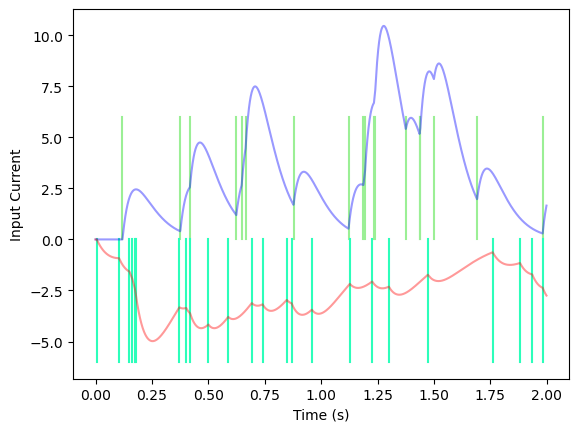

In [39]:
%matplotlib inline
plt.figure(7)
PlotSpikeRaster([A], y_range=[0,6])
PlotSpikeRaster([B], y_range=[-6,0])
plt.plot(t2, w_AC*p_AC, 'b', alpha=0.4)
plt.plot(t2, w_BC*p_BC, 'r', alpha=0.4)
plt.xlabel('Time (s)'); plt.ylabel('Input Current');
plt.axis('auto');

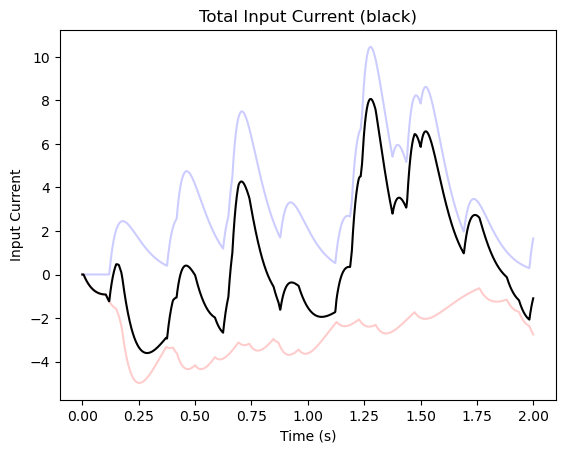

In [40]:
plt.figure(8)
plt.plot(t2, w_AC*p_AC, 'b', alpha=0.2)
plt.plot(t2, w_BC*p_BC, 'r', alpha=0.2)
plt.plot(t2, w_AC*p_AC + w_BC*p_BC, 'k')
plt.xlabel('Time (s)'); plt.ylabel('Input Current');
plt.title('Total Input Current (black)');

## Constant firing rates

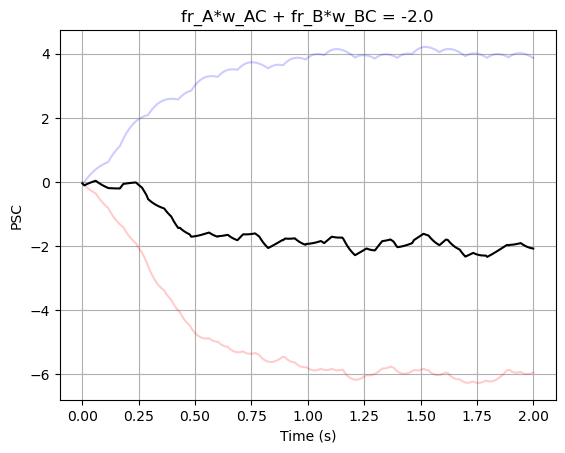

In [41]:
T = 3
fr_A = 10; w_AC = 0.4
fr_B = 20; w_BC = -0.3
A = DemoSpikeTrain(fr_A, T, jitter=0.02)
B = DemoSpikeTrain(fr_B, T, jitter=0.02)
p_AC = Spikes2PSC(t2, A, tau_s=0.2, n=1)
p_BC = Spikes2PSC(t2, B, tau_s=0.2, n=1)
%matplotlib inline
fig = plt.figure(9); ax = fig.add_subplot(1,1,1)
lineCA, = ax.plot(t2, w_AC*p_AC, 'b', alpha=0.2);
lineCB, = ax.plot(t2, w_BC*p_BC, 'r', alpha=0.2);
lineBoth, = ax.plot(t2, w_AC*p_AC + w_BC*p_BC, 'k');
ax.set_xlabel('Time (s)'); ax.set_ylabel('PSC');
ax.grid('on'); plt.title(f'fr_A*w_AC + fr_B*w_BC = {fr_A*w_AC + fr_B*w_BC}');

In [42]:
T = 3
fr_A = 10
fr_B = 20
A = DemoSpikeTrain(fr_A, T, jitter=0.02)
B = DemoSpikeTrain(fr_B, T, jitter=0.02)
p_AC = Spikes2PSC(t2, A, tau_s=0.2, n=1)
p_BC = Spikes2PSC(t2, B, tau_s=0.2, n=1)
%matplotlib osx
fig = plt.figure(9); ax = fig.add_subplot(1,1,1)
lineCA, = ax.plot(t2, w_AC*p_AC, 'b', alpha=0.2);
lineCB, = ax.plot(t2, w_BC*p_BC, 'r', alpha=0.2);
lineBoth, = ax.plot(t2, w_AC*p_AC + w_BC*p_BC, 'k');
ax.set_ylim(-8, 8)
ax.set_xlabel('Time (s)'); ax.set_ylabel('PSC');

def update(w_AC=0.4, w_BC=0.25):
    lineCA.set_ydata(w_AC*p_AC)
    lineCB.set_ydata(w_BC*p_BC)
    lineBoth.set_ydata(w_AC*p_AC + w_BC*p_BC)
    fig.canvas.draw_idle()
    plt.title(f'fr_A*w_AC + fr_B*w_BC = {fr_A*w_AC + fr_B*w_BC}')
    plt.grid('on')

blah = widgets.interact(update, w_AC=widgets.FloatSlider(value=0.4, min=-0.5, max=0.5, step=0.01, readout_format='.3f'),
                       w_BC=widgets.FloatSlider(value=-0.25, min=-0.5, max=0.5, step=0.01, readout_format='.3f'))

interactive(children=(FloatSlider(value=0.4, description='w_AC', max=0.5, min=-0.5, readout_format='.3f', step…